### Install dependencies and import libraries

In [7]:
from dataclasses import dataclass
from typing import Optional, List
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy
from langchain.tools import tool, ToolRuntime
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import InMemorySaver
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.prompts import ChatPromptTemplate

### Creating the input node for essay content upload
- essay content: contains the content of the essay of a specific student

In [8]:
pdf_path = "C:\\Users\\HP\\Documents\\repos\\langchain-mastery-ai-angineers\\data\\essay_content.pdf"
loader = PyPDFLoader(pdf_path)
docs = loader.load()
docs

[Document(metadata={'producer': 'Microsoft® Word 2024', 'creator': 'Microsoft® Word 2024', 'creationdate': '2025-12-16T14:12:31+08:00', 'author': 'hp404sk7@outlook.com', 'moddate': '2025-12-16T14:12:31+08:00', 'source': 'C:\\Users\\HP\\Documents\\repos\\langchain-mastery-ai-angineers\\data\\essay_content.pdf', 'total_pages': 3, 'page': 0, 'page_label': '1'}, page_content='2. Student Essay Submission \nTitle \nBeyond Prohibition: Integrating Generative AI into Higher Education Assessment \nand Learning \n \nIntroduction \nThe rapid emergence of Generative Artificial Intelligence (GenAI) tools, such as ChatGPT \nand Claude, has fundamentally disrupted the landscape of higher education. While \ndigital tools have long supported academic study, GenAI’s ability to synthesise complex \ninformation and generate human-like text presents unprecedented challenges to \nestablished educational norms. \nA key concern among educators is the threat these tools pose to academic integrity, \nparticular

### Create Knowledge Base for specific essay question and rubric
- essay question: contains essay question and descriptions
- essay rubric: contains the marking rubric for the essay 

### Create Fact Extractor LLM 
- to extract facts from essay content and output a JSON format 

In [9]:
from dotenv import load_dotenv
import os

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.environ.get("GOOGLE_API_KEY")

In [10]:
from pydantic import BaseModel, Field
from langchain.agents.structured_output import ToolStrategy

class FactsInfo(BaseModel):
    statement: str = Field(
            ..., 
            description="The factual claim made by the student."
        )
    source_quote: str = Field(
            ..., 
            description="The exact sentence or phrase from the essay where this fact is mentioned."
        )
    page_number: int = Field(
            ..., 
            description="The page number where this fact was found."
        )

# 2. Define the container for the facts (the final JSON structure)
class FactExtraction(BaseModel):
    facts: List[FactsInfo]

In [11]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0
)

# Bind the schema to the model
structured_llm = llm.with_structured_output(FactExtraction)

In [12]:
system_prompt = """
You are an expert fact-checker. 
Extract every distinct factual claim made in the text provided.
Ignore opinions or transitional phrases.
For every fact, you must provide the exact quote from the text.
"""

In [13]:
prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", "{text}")
])

extraction_chain = prompt | structured_llm

In [14]:
all_facts_with_metadata = []

print(f"Processing {len(docs)} pages using Google Gemini...")

for doc in docs:
    page_num = doc.metadata.get('page', 0) + 1
    page_content = doc.page_content
    
    # Skip empty pages to save API calls
    if not page_content.strip():
        continue

    try:
        # We only send the text to the LLM
        result = extraction_chain.invoke({"text": page_content})
        
        # We attach the page number manually here.
        # This is safer than asking the LLM to guess the page number.
        if result and result.facts:
            for fact in result.facts:
                fact_dict = fact.dict()
                fact_dict['page_number'] = page_num
                all_facts_with_metadata.append(fact_dict)
                
    except Exception as e:
        print(f"Error on page {page_num}: {e}")

Processing 3 pages using Google Gemini...


C:\Users\HP\AppData\Local\Temp\ipykernel_11988\181452761.py:21: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  fact_dict = fact.dict()


In [15]:
for fact in all_facts_with_metadata:
    print(fact)

{'statement': 'Generative Artificial Intelligence (GenAI) tools, such as ChatGPT and Claude, have rapidly emerged.', 'source_quote': 'The rapid emergence of Generative Artificial Intelligence (GenAI) tools, such as ChatGPT and Claude, has fundamentally disrupted the landscape of higher education.', 'page_number': 1}
{'statement': 'GenAI has the ability to synthesise complex information and generate human-like text.', 'source_quote': 'GenAI’s ability to synthesise complex information and generate human-like text presents unprecedented challenges to established educational norms.', 'page_number': 1}
{'statement': 'Baron (2023) highlights that existing plagiarism detection software increasingly struggles to distinguish between human and AI-produced text.', 'source_quote': 'Baron (2023) highlights that existing plagiarism detection software increasingly struggles to distinguish between human and AI-produced text, creating a “crisis of trust” in grading systems.', 'page_number': 1}
{'statem

## Create Fact Evaluator Agent
- evaluate facts by conducting similarity search on the knowledge base
- if not found search online for useful sources
- follows Corrective RAG workflow
- There are 2 ways to do this 
    - using CRAG LangGraph Implementation
    - using LangChain Agents implementation

Input:
- facts: JSON
- system prompt: instructions to follow corrective RAG workflow

### Implementation 1:
- using CRAG Langgraph 

Corrective-RAG (CRAG) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents.

In the paper here, a few steps are taken:

If at least one document exceeds the threshold for relevance, then it proceeds to generation
Before generation, it performs knowledge refinement
This partitions the document into "knowledge strips"
It grades each strip, and filters our irrelevant ones
If all documents fall below the relevance threshold or if the grader is unsure, then the framework seeks an additional datasource
It will use web search to supplement retrieval
We will implement some of these ideas from scratch using LangGraph:

Let's skip the knowledge refinement phase as a first pass. This can be added back as a node, if desired.
If any documents are irrelevant, let's opt to supplement retrieval with web search.
We'll use Tavily Search for web search.
Let's use query re-writing to optimize the query for web search.

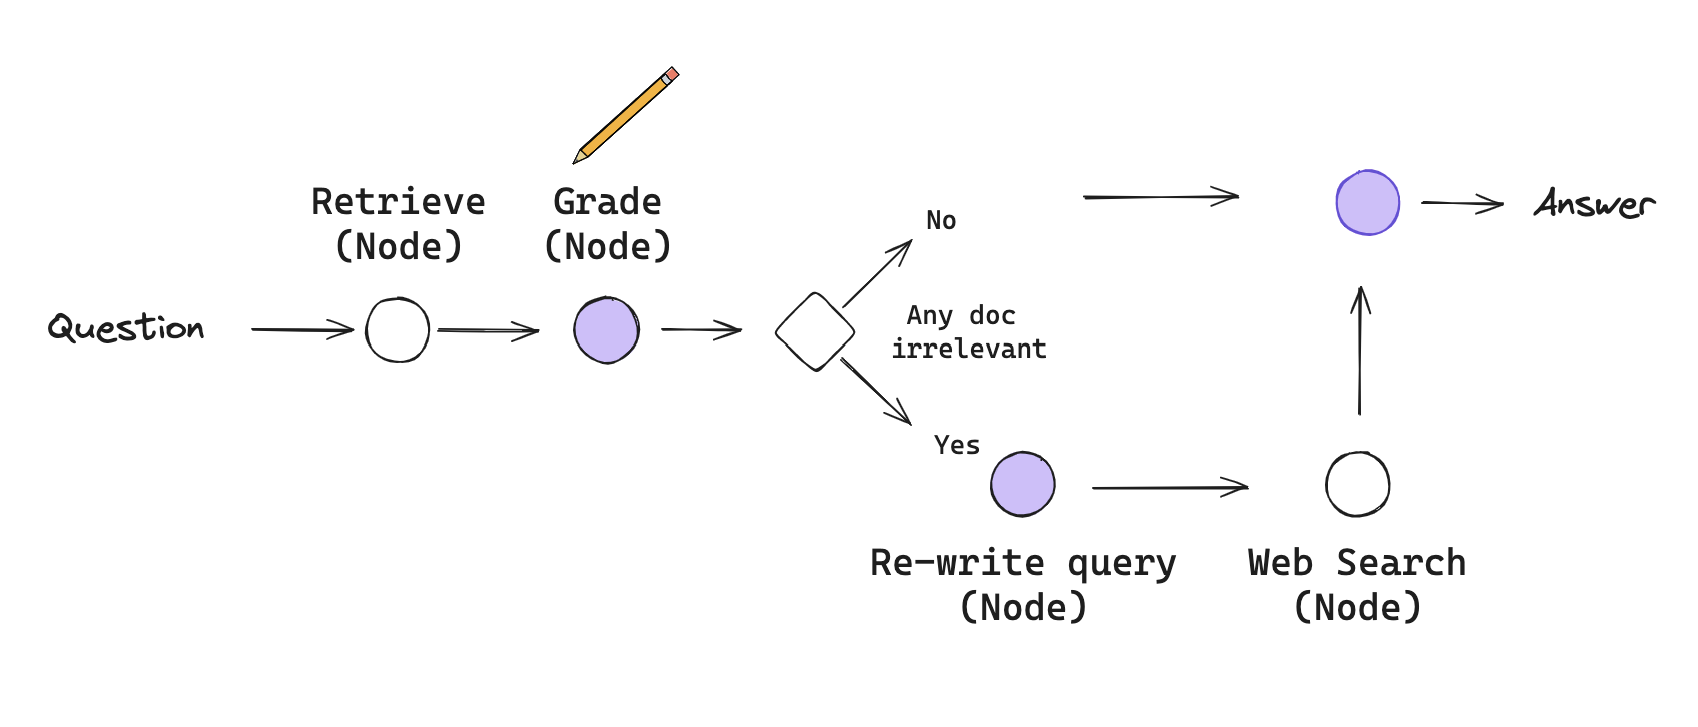